In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

from skimage.io import imread
from scipy.signal import convolve2d

# from scipy.stats import expon
# from scipy.optimize import curve_fit

from scipy.stats import cauchy, norm #chi2, erlang, expon, genexpon, ncx2, poisson, powerlaw, rayleigh

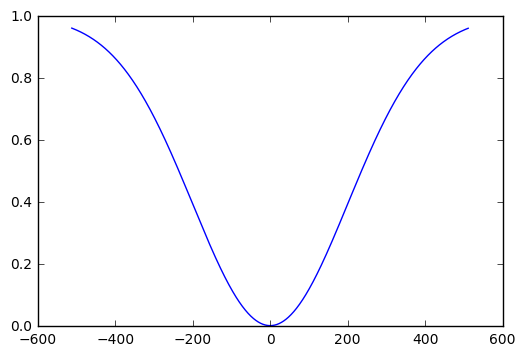

In [43]:
x = np.arange(-512.0, 512.0)

s = 200
y = 2.5*s*norm.pdf(x, loc=0, scale=s)
plt.plot(x,1-y)

In [416]:
# image_list = glob('/home/pvt/Workspace/multibeam-classification/dataset-1/*raw.png') # window set to 2.25m to 11.25m
image_list = glob('/home/pvt/Workspace/multibeam/data/DIDSON/2016-07-19.11/*raw.png') # window set to 2.25m to 11.25m
print len(image_list)

import cv2
from multibeam import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('data/DIDSON/didson.json')

41487
Resolution
Desired: 0.02 , x: 0.0199847165996 , y: 0.0200030206842
Resolution
Desired: 0.02 , x: 0.019980559264 , y: 0.0200144258506


image: 14811
0.0 0.556862745098
(512, 96)


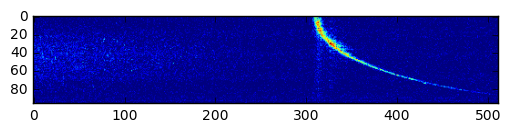

In [426]:
idx = np.random.randint(0,len(image_list))
# idx=30950
# 40891 - reverb
print 'image:',idx
# img = imread(image_list[idx], as_grey=True)
ping = cv2.imread(image_list[idx],cv2.CV_LOAD_IMAGE_GRAYSCALE)
# img = didson.deconvolve(ping)
img = ping
img = img.astype(np.float64)/255.0
print np.amin(img), np.amax(img)
print img.shape
plt.imshow(img.transpose())

In [431]:
%%timeit

"""
Tunable parameters:
- Cauchy scale
- Transition cost & cooling
- relative weight (u0/u1)
- 1st-order void-label cost

To Do:
- better edge handling on roll 
- handle "void" labels on transition cost (should get replaced by fixed cost!)
"""


# c_scale = 0.33
c_scale = 1
#get a prior on the labels
midx = np.argmax(img, axis=0) # return max location per row
midx.shape = (1,96)

# pre-allocate vector used to evaluate Cauchy functions
x = np.arange(0.0,512.0, 1.0)
x.shape = (512,1)
x = np.tile(x,(1,96))
    
# c = cauchy.pdf(x, loc = midx, scale=0.33)    
# u0 = np.sum(np.square)
# u0void = np.square

# compute 0-order label cost map 
u0 = np.zeros_like(x)
    
# one for each range assignment
for i in range(0,512):
    u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)
    
# 'void' label
u0v = np.sum(np.square(img),axis=0) 
# u0 = np.vstack((u0v,u0))

s = 100
# now, iterate so as to get 
# for i in range(0,20):
i = 0
while True:
    i = i+1
    # TODO: fix edge effects - replace with own value to zero the difference
    
    a = np.tile(midx,(512,1))
    l = np.roll(a,1,axis=1)
    l[:,0]=l[:,1]
    ll = np.roll(l,1, axis=1)
    ll[:,0]=ll[:,1]
    r = np.roll(a,-1,axis=1)
    r[:,-1] = r[:,-2]
    rr = np.roll(r,-1, axis=1)
    rr[:,-1] = rr[:,-2]
    
#     s = 20*(20 - i)
    s = 0.95*s;
#     u1 = 2 - 2.5*s*norm.pdf((l-x),loc=0, scale=s ) - 2.5*s*norm.pdf((r-x),loc=0, scale=s )
    u1 = 4 - 2.5*s*norm.pdf((l-x),loc=0, scale=s ) - 2.5*s*norm.pdf((r-x),loc=0, scale=s ) - 2.5*s*norm.pdf((ll-x),loc=0, scale=s ) - 2.5*s*norm.pdf((rr-x),loc=0, scale=s )

#     u1 = np.vstack((0.5*np.ones_like(u0v),u1))

#     print 'u0:',np.amin(u0),'-',np.amax(u0)
#     print 'u1:',np.amin(u1),'-',np.amax(u1)
#     print 's:',s
    cost = u0 + u1
    midx_new = np.argmin(cost, axis=0)

#     print np.amin(cost),np.amax(cost)
#     print u0.shapes
#     midx_new = np.argmin(u0, axis=0)

    changes = np.sum((midx-midx_new)!=0)
#     print 'changes:',changes
    midx = midx_new
    
#     plt.figure(figsize=(10,4))
#     plt.imshow((cost).transpose())
    
    if s<10:
        break
    
    if changes<=0:
        break
        
    if i>100:
        break

        
# print 'iterations:',i
# plt.figure(figsize=(10,4))
# plt.imshow(cost.transpose())
        
# simg = cauchy.pdf(x,loc=midx, scale=c_scale)
# plt.figure(figsize=(10,4))
# plt.imshow(simg.transpose())

# plt.figure(figsize=(10,4))
# plt.imshow(img.transpose())
# plt.title('Original')

1 loop, best of 3: 1.96 s per loop


In [76]:
a = np.array([[1,2],[3,4]])
print np.roll(a,1,axis=0)

[[3 4]
 [1 2]]


In [106]:
 
    

midx = np.tile(idx, (512,1))
print idx.shape



## 
iimg = np.zeros_like(img)
x = np.arange(0.0,512.0, 1.0)
for i in range(0,96):
    iimg[:,i] = cauchy.pdf(x, loc = idx[i],scale=0.33)

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.imshow(img.transpose())
plt.subplot(2,1,2)
plt.imshow(iimg.transpose())
plt.show()

(512, 96)


ValueError: operands could not be broadcast together with shapes (512,) (96,) 

In [95]:
beam = 30

i = np.where(img[:,beam] == img[:,beam].max())
print i[0][0]
l = i[0][0]
d = img[:,0] - cauchy.pdf(x,loc = l, scale = 0.33)
print 'argmax:',np.sum(np.square(d))
print 'void:  ',np.sum(np.square(img[:,beam]))


82
argmax: 1.38151322914
void:   2.57723952326


In [383]:
x = np.array([1, 2, 3, 4, 5])
a = np.roll(x,-1)
a[-1] = a[-2]
print a

[2 3 4 5 5]


In [104]:
x = np.ones((10,10))
l = np.ones((10,10))
l[:,1] = 2
l[:,2] = 4
print l
s = 0.33*np.ones((10,10))
y = cauchy.pdf(x, loc=l, scale = s)
print y

[[ 1.  2.  4.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  2.  4.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  2.  4.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  2.  4.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  2.  4.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  2.  4.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  2.  4.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  2.  4.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  2.  4.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  2.  4.  1.  1.  1.  1.  1.  1.  1.]]
[[ 0.96457541  0.09472654  0.01153183  0.96457541  0.96457541  0.96457541
   0.96457541  0.96457541  0.96457541  0.96457541]
 [ 0.96457541  0.09472654  0.01153183  0.96457541  0.96457541  0.96457541
   0.96457541  0.96457541  0.96457541  0.96457541]
 [ 0.96457541  0.09472654  0.01153183  0.96457541  0.96457541  0.96457541
   0.96457541  0.96457541  0.96457541  0.96457541]
 [ 0.96457541  0.09472654  0.01153183  0.96457541  0.96457541  0.96457541
   0.96457541  0.96457541  0.96457541  0.96457541]
 [ 0.96457541  0.09472654  0.01153183  0.96457541  0.96457541  0.9645